## Obtaining a dataset of agtech-related stories on Hacker News

When I first tried to query for agtech-related stories on HN, I ended up with a small dataset of <100 rows because the search terms was too narrow. In this notebook, I'll start with a wide query for any stories containing ag(-)/agri(-)/farm. From this initial large dataset, I can then narrow them down to the stories related to ag(ri)tech (i.e. agricultural technology) by selecting stories containing relevant bigrams.

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re  
import spacy

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fangn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fangn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from google.cloud import bigquery

In [4]:
client = bigquery.Client()

query = """
SELECT title, type, score, descendants AS comments, timestamp, url
FROM `bigquery-public-data.hacker_news.full`
WHERE REGEXP_CONTAINS(title, r"(?:(a|A)g)(ri)(?:(\-|\ |))?") OR REGEXP_CONTAINS(title, r"\\b(a|A)g(\-)?\\b") OR REGEXP_CONTAINS(title, r"(f|F)arm")
ORDER BY timestamp
"""

ag_farm_df = client.query(query).to_dataframe()
ag_farm_df

,title,type,score,comments,timestamp,url
0,Possibility of running single-system-image clu...,story,1,1.0,2007-05-05 03:43:55+00:00,None
1,Life of a Chinese Gold Farmer,story,21,43.0,2007-06-17 18:45:50+00:00,http://www.nytimes.com/2007/06/17/magazine/17l...
2,What's the best health insurance company for c...,story,1,3.0,2007-06-23 23:06:55+00:00,None
3,"""Crowd Farm"": turn the mechanical energy of pe...",story,1,0.0,2007-08-03 19:36:19+00:00,http://www.physorg.com/news104679881.html
4,Folding Farmer - Folding @ Home As A Service,story,2,0.0,2007-08-30 21:14:45+00:00,http://foldingfarmer.com/products/faas-folding...
...,...,...,...,...,...,...
4907,Is It Possible to Avoid Yield Farms That Use L...,story,1,NaN,2021-02-17 04:10:39+00:00,https://www.reddit.com/r/ethfinance/comments/l...
4908,Corn belt farmland has lost a third of its car...,story,1,1.0,2021-02-17 15:32:22+00:00,https://phys.org/news/2021-02-corn-belt-farmla...
4909,Vertical farming does not save space,story,4,1.0,2021-02-17 16:17:05+00:00,https://solar.lowtechmagazine.com/2021/02/vert...
4910,FarmOS – web-based application for farm manage...,story,3,0.0,2021-02-17 18:20:38+00:00,https://farmos.org


proposed sequence of steps:  
1. lowercase all words 
2. remove punctuation
3. convert into tokens
4. lemmatise (i.e. make them into root words)
5. create bigrams
6. prune bigrams containing stopwords

In [5]:
# convert all characters to lowercase in 
ag_farm_df['title_lowercase']=ag_farm_df['title'].str.lower()
ag_farm_df

,title,type,score,comments,timestamp,url,title_lowercase
0,Possibility of running single-system-image clu...,story,1,1.0,2007-05-05 03:43:55+00:00,None,possibility of running single-system-image clu...
1,Life of a Chinese Gold Farmer,story,21,43.0,2007-06-17 18:45:50+00:00,http://www.nytimes.com/2007/06/17/magazine/17l...,life of a chinese gold farmer
2,What's the best health insurance company for c...,story,1,3.0,2007-06-23 23:06:55+00:00,None,what's the best health insurance company for c...
3,"""Crowd Farm"": turn the mechanical energy of pe...",story,1,0.0,2007-08-03 19:36:19+00:00,http://www.physorg.com/news104679881.html,"""crowd farm"": turn the mechanical energy of pe..."
4,Folding Farmer - Folding @ Home As A Service,story,2,0.0,2007-08-30 21:14:45+00:00,http://foldingfarmer.com/products/faas-folding...,folding farmer - folding @ home as a service
...,...,...,...,...,...,...,...
4907,Is It Possible to Avoid Yield Farms That Use L...,story,1,NaN,2021-02-17 04:10:39+00:00,https://www.reddit.com/r/ethfinance/comments/l...,is it possible to avoid yield farms that use l...
4908,Corn belt farmland has lost a third of its car...,story,1,1.0,2021-02-17 15:32:22+00:00,https://phys.org/news/2021-02-corn-belt-farmla...,corn belt farmland has lost a third of its car...
4909,Vertical farming does not save space,story,4,1.0,2021-02-17 16:17:05+00:00,https://solar.lowtechmagazine.com/2021/02/vert...,vertical farming does not save space
4910,FarmOS – web-based application for farm manage...,story,3,0.0,2021-02-17 18:20:38+00:00,https://farmos.org,farmos – web-based application for farm manage...


In [6]:
# remove punctuation from title column
ag_farm_df['title_lowercase'] = ag_farm_df['title_lowercase'].str.replace('[^\w\s]','')
ag_farm_df

C:\Users\fangn\anaconda3\envs\hackernews\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,title,type,score,comments,timestamp,url,title_lowercase
0,Possibility of running single-system-image clu...,story,1,1.0,2007-05-05 03:43:55+00:00,None,possibility of running singlesystemimage clust...
1,Life of a Chinese Gold Farmer,story,21,43.0,2007-06-17 18:45:50+00:00,http://www.nytimes.com/2007/06/17/magazine/17l...,life of a chinese gold farmer
2,What's the best health insurance company for c...,story,1,3.0,2007-06-23 23:06:55+00:00,None,whats the best health insurance company for ca...
3,"""Crowd Farm"": turn the mechanical energy of pe...",story,1,0.0,2007-08-03 19:36:19+00:00,http://www.physorg.com/news104679881.html,crowd farm turn the mechanical energy of peopl...
4,Folding Farmer - Folding @ Home As A Service,story,2,0.0,2007-08-30 21:14:45+00:00,http://foldingfarmer.com/products/faas-folding...,folding farmer folding home as a service
...,...,...,...,...,...,...,...
4907,Is It Possible to Avoid Yield Farms That Use L...,story,1,NaN,2021-02-17 04:10:39+00:00,https://www.reddit.com/r/ethfinance/comments/l...,is it possible to avoid yield farms that use l...
4908,Corn belt farmland has lost a third of its car...,story,1,1.0,2021-02-17 15:32:22+00:00,https://phys.org/news/2021-02-corn-belt-farmla...,corn belt farmland has lost a third of its car...
4909,Vertical farming does not save space,story,4,1.0,2021-02-17 16:17:05+00:00,https://solar.lowtechmagazine.com/2021/02/vert...,vertical farming does not save space
4910,FarmOS – web-based application for farm manage...,story,3,0.0,2021-02-17 18:20:38+00:00,https://farmos.org,farmos webbased application for farm manageme...


In [7]:
# tokenise title column
ag_farm_df['title_tokens'] = ag_farm_df['title_lowercase'].apply(word_tokenize)

In [8]:
# lemmatise title_tokens column
# which may be a bit tricky since the title_tokens contains lists of the tokens
lmtzr = WordNetLemmatizer()
ag_farm_df['title_lemmas'] = ag_farm_df['title_tokens'].apply(lambda lst:[lmtzr.lemmatize(word) for word in lst])
ag_farm_df

,title,type,score,comments,timestamp,url,title_lowercase,title_tokens,title_lemmas
0,Possibility of running single-system-image clu...,story,1,1.0,2007-05-05 03:43:55+00:00,None,possibility of running singlesystemimage clust...,"[possibility, of, running, singlesystemimage, ...","[possibility, of, running, singlesystemimage, ..."
1,Life of a Chinese Gold Farmer,story,21,43.0,2007-06-17 18:45:50+00:00,http://www.nytimes.com/2007/06/17/magazine/17l...,life of a chinese gold farmer,"[life, of, a, chinese, gold, farmer]","[life, of, a, chinese, gold, farmer]"
2,What's the best health insurance company for c...,story,1,3.0,2007-06-23 23:06:55+00:00,None,whats the best health insurance company for ca...,"[whats, the, best, health, insurance, company,...","[whats, the, best, health, insurance, company,..."
3,"""Crowd Farm"": turn the mechanical energy of pe...",story,1,0.0,2007-08-03 19:36:19+00:00,http://www.physorg.com/news104679881.html,crowd farm turn the mechanical energy of peopl...,"[crowd, farm, turn, the, mechanical, energy, o...","[crowd, farm, turn, the, mechanical, energy, o..."
4,Folding Farmer - Folding @ Home As A Service,story,2,0.0,2007-08-30 21:14:45+00:00,http://foldingfarmer.com/products/faas-folding...,folding farmer folding home as a service,"[folding, farmer, folding, home, as, a, service]","[folding, farmer, folding, home, a, a, service]"
...,...,...,...,...,...,...,...,...,...
4907,Is It Possible to Avoid Yield Farms That Use L...,story,1,NaN,2021-02-17 04:10:39+00:00,https://www.reddit.com/r/ethfinance/comments/l...,is it possible to avoid yield farms that use l...,"[is, it, possible, to, avoid, yield, farms, th...","[is, it, possible, to, avoid, yield, farm, tha..."
4908,Corn belt farmland has lost a third of its car...,story,1,1.0,2021-02-17 15:32:22+00:00,https://phys.org/news/2021-02-corn-belt-farmla...,corn belt farmland has lost a third of its car...,"[corn, belt, farmland, has, lost, a, third, of...","[corn, belt, farmland, ha, lost, a, third, of,..."
4909,Vertical farming does not save space,story,4,1.0,2021-02-17 16:17:05+00:00,https://solar.lowtechmagazine.com/2021/02/vert...,vertical farming does not save space,"[vertical, farming, does, not, save, space]","[vertical, farming, doe, not, save, space]"
4910,FarmOS – web-based application for farm manage...,story,3,0.0,2021-02-17 18:20:38+00:00,https://farmos.org,farmos webbased application for farm manageme...,"[farmos, webbased, application, for, farm, man...","[farmos, webbased, application, for, farm, man..."


The below cells show how to get rid of the generators when generating ngrams.

In [9]:
ag_farm_df['title_bigrams'] = ag_farm_df['title_lemmas'].apply(lambda row: list(nltk.ngrams(row, 2)))
ag_farm_df

,title,type,score,comments,timestamp,url,title_lowercase,title_tokens,title_lemmas,title_bigrams
0,Possibility of running single-system-image clu...,story,1,1.0,2007-05-05 03:43:55+00:00,None,possibility of running singlesystemimage clust...,"[possibility, of, running, singlesystemimage, ...","[possibility, of, running, singlesystemimage, ...","[(possibility, of), (of, running), (running, s..."
1,Life of a Chinese Gold Farmer,story,21,43.0,2007-06-17 18:45:50+00:00,http://www.nytimes.com/2007/06/17/magazine/17l...,life of a chinese gold farmer,"[life, of, a, chinese, gold, farmer]","[life, of, a, chinese, gold, farmer]","[(life, of), (of, a), (a, chinese), (chinese, ..."
2,What's the best health insurance company for c...,story,1,3.0,2007-06-23 23:06:55+00:00,None,whats the best health insurance company for ca...,"[whats, the, best, health, insurance, company,...","[whats, the, best, health, insurance, company,...","[(whats, the), (the, best), (best, health), (h..."
3,"""Crowd Farm"": turn the mechanical energy of pe...",story,1,0.0,2007-08-03 19:36:19+00:00,http://www.physorg.com/news104679881.html,crowd farm turn the mechanical energy of peopl...,"[crowd, farm, turn, the, mechanical, energy, o...","[crowd, farm, turn, the, mechanical, energy, o...","[(crowd, farm), (farm, turn), (turn, the), (th..."
4,Folding Farmer - Folding @ Home As A Service,story,2,0.0,2007-08-30 21:14:45+00:00,http://foldingfarmer.com/products/faas-folding...,folding farmer folding home as a service,"[folding, farmer, folding, home, as, a, service]","[folding, farmer, folding, home, a, a, service]","[(folding, farmer), (farmer, folding), (foldin..."
...,...,...,...,...,...,...,...,...,...,...
4907,Is It Possible to Avoid Yield Farms That Use L...,story,1,NaN,2021-02-17 04:10:39+00:00,https://www.reddit.com/r/ethfinance/comments/l...,is it possible to avoid yield farms that use l...,"[is, it, possible, to, avoid, yield, farms, th...","[is, it, possible, to, avoid, yield, farm, tha...","[(is, it), (it, possible), (possible, to), (to..."
4908,Corn belt farmland has lost a third of its car...,story,1,1.0,2021-02-17 15:32:22+00:00,https://phys.org/news/2021-02-corn-belt-farmla...,corn belt farmland has lost a third of its car...,"[corn, belt, farmland, has, lost, a, third, of...","[corn, belt, farmland, ha, lost, a, third, of,...","[(corn, belt), (belt, farmland), (farmland, ha..."
4909,Vertical farming does not save space,story,4,1.0,2021-02-17 16:17:05+00:00,https://solar.lowtechmagazine.com/2021/02/vert...,vertical farming does not save space,"[vertical, farming, does, not, save, space]","[vertical, farming, doe, not, save, space]","[(vertical, farming), (farming, doe), (doe, no..."
4910,FarmOS – web-based application for farm manage...,story,3,0.0,2021-02-17 18:20:38+00:00,https://farmos.org,farmos webbased application for farm manageme...,"[farmos, webbased, application, for, farm, man...","[farmos, webbased, application, for, farm, man...","[(farmos, webbased), (webbased, application), ..."


In [ ]:
from itertools import chain
bigrams_lst = list(chain(*list(ag_farm_df['title_bigrams'])))
bigrams_lst

In [11]:
len(bigrams_lst)

37764

In [ ]:
# remove bigrams containing stop words 
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words

In [13]:
# write a function that saves the bigram from bigram_lst if it does not contain stopwords 

def contains_stop(bigram, my_stop_words):
    if any([(stop in bigram) for stop in my_stop_words]):
        return True
    else: 
        return False

In [14]:
# this is the clearest (and fastest) version of performing the same check
def contains_stop(bigram, my_stop_words):
    if my_stop_words.intersection(bigram):
        return True
    else: 
        return False

In [ ]:
clean = [bigram for bigram in bigrams_lst if not contains_stop(bigram, stop_words)]

In [16]:
# count frequency of bigrams
from nltk import FreqDist
fdist =  FreqDist(clean)

In [17]:
fdist.most_common(100)

[(('wind', 'farm'), 161),
 (('solar', 'farm'), 99),
 (('content', 'farm'), 91),
 (('offshore', 'wind'), 53),
 (('server', 'farm'), 51),
 (('climate', 'change'), 50),
 (('ask', 'hn'), 49),
 (('vertical', 'farm'), 49),
 (('show', 'hn'), 43),
 (('farmer', 'market'), 37),
 (('world', 'largest'), 37),
 (('vertical', 'farming'), 35),
 (('indian', 'farmer'), 31),
 (('click', 'farm'), 29),
 (('world', 'first'), 28),
 (('urban', 'farming'), 27),
 (('chinese', 'farmer'), 24),
 (('animal', 'farm'), 23),
 (('help', 'farmer'), 23),
 (('farm', 'could'), 22),
 (('open', 'source'), 22),
 (('organic', 'farming'), 22),
 (('farm', 'animal'), 21),
 (('american', 'farmer'), 21),
 (('farmer', 'protest'), 21),
 (('troll', 'farm'), 21),
 (('factory', 'farm'), 20),
 (('indoor', 'farm'), 20),
 (('farmlogs', 'yc'), 20),
 (('yc', 'w12'), 20),
 (('device', 'farm'), 20),
 (('u', 'farm'), 19),
 (('farm', 'worker'), 18),
 (('facebook', 'partner'), 18),
 (('shadowy', 'data'), 18),
 (('data', 'broker'), 18),
 (('family

The nltk.FreqDist object is a subtype of the native collections.Counter which is a native dict subclass. So I should be able to plot a bar chart with the dictionary?

In [18]:
# construct 2-column df from dict
bigrams_freq_df = pd.DataFrame.from_dict(fdist, orient='index').reset_index()

# rename columns
bigrams_freq_df = bigrams_freq_df.rename(columns={'index':'bigram', 0:'count'})

# remove parantheses and commas
bigrams_freq_df['bigram'] = bigrams_freq_df['bigram'].astype(str).str.replace(r'\(|\)|,','')

#sort by descending order
bigrams_freq_df.sort_values(by='count', ascending = False)


C:\Users\fangn\anaconda3\envs\hackernews\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


,bigram,count
30,'wind' 'farm',161
1608,'solar' 'farm',99
581,'content' 'farm',91
814,'offshore' 'wind',53
57,'server' 'farm',51
...,...,...
4972,'discussing' 'ag',1
4973,'farmer' 'object',1
4975,'food' 'rating',1
4977,'frugal' 'farm',1


In [19]:
# save top 100 bigrams into separate df
top_100_bigrams = bigrams_freq_df.nlargest(100,'count')
top_100_bigrams

,bigram,count
30,'wind' 'farm',161
1608,'solar' 'farm',99
581,'content' 'farm',91
814,'offshore' 'wind',53
57,'server' 'farm',51
...,...,...
75,'farm' 'work',8
419,'north' 'carolina',8
781,'local' 'farmer',8
807,'look' 'like',8


In [20]:
top_20_bigrams = bigrams_freq_df.nlargest(20,'count')
top_20_bigrams

,bigram,count
30,'wind' 'farm',161
1608,'solar' 'farm',99
581,'content' 'farm',91
814,'offshore' 'wind',53
57,'server' 'farm',51
525,'climate' 'change',50
100,'ask' 'hn',49
1059,'vertical' 'farm',49
2726,'show' 'hn',43
283,'farmer' 'market',37


In [21]:
# look beyond the top 100 to see if there are other relevant bigrams
bigrams_freq_df.sort_values(by='count', ascending = False).iloc[100:151,] #note second index is not inclusive

,bigram,count
1375,'e' 'farm',8
807,'look' 'like',8
12971,'russian' 'cyberpunk',8
7145,'transform' 'agriculture',8
2902,'ag' 'tech',8
1410,'farmer' 'update',8
781,'local' 'farmer',8
2487,'farmville' '2',8
2962,'study' 'find',8
1082,'robotic' 'farm',8


In [22]:
# look beyond the top 100 to see if there are other relevant bigrams
bigrams_freq_df.sort_values(by='count', ascending = False).iloc[151:200,] #note second index is not inclusive

,bigram,count
9446,'african' 'swine',6
4,'gold' 'farmer',6
4025,'animal' 'agriculture',6
4951,'coffee' 'farm',6
3241,'robot' 'farm',6
8258,'interview' 'section',6
5044,'led' 'light',6
5916,'ocean' 'farmer',6
3623,'farmington' 'hill',6
3624,'hill' 'mi',6


In [23]:
top_100_bigrams.dtypes

bigram    object
count      int64
dtype: object

In [24]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

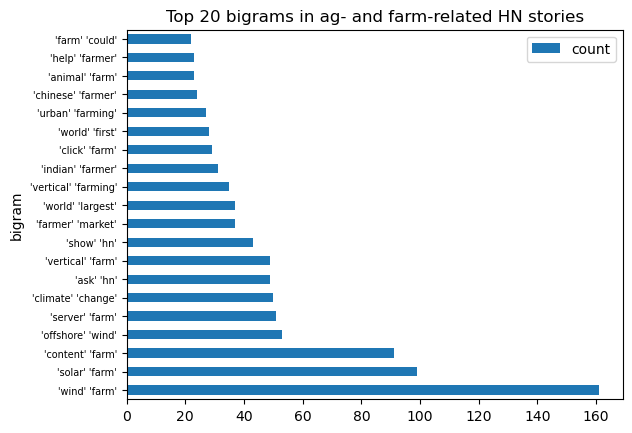

In [25]:
ax = top_20_bigrams.plot.barh(x='bigram', y='count', title='Top 20 bigrams in ag- and farm-related HN stories')
ax.tick_params(axis='y', labelsize=7)

The top 20 bigrams contain quite a few irrelevant bigrams (e.g. wind farm, solar farm, ask HN) so I think it would be best to examine the top 100 bigrams dataframe instead.

Using the bigrams relevant to agritech, I'll sift through and save a dataset that contains only stories relevant to this topic.

proposed process to vet titles: go down list of bigrams, pick out the agtech-related bigrams, filter out rows containing any one of these bigrams and save to a new df

In [26]:
# try filtering on one bigram
# if any str[i] in ['title_bigrams'] matches the selected bigram then return T else F
selection = [('vertical', 'farm'), ('vertical', 'farming')]
mask = ag_farm_df.title_bigrams.apply(lambda x: any(item for item in selection if item in x))
ag_farm_df[mask]
# so this works!! so now i can create a selection containing the bigrams extracted using their indices

,title,type,score,comments,timestamp,url,title_lowercase,title_tokens,title_lemmas,title_bigrams
128,Vertical Farming: A Farm on Every Floor,story,2,0.0,2009-08-24 13:38:00+00:00,http://www.nytimes.com/2009/08/24/opinion/24De...,vertical farming a farm on every floor,"[vertical, farming, a, farm, on, every, floor]","[vertical, farming, a, farm, on, every, floor]","[(vertical, farming), (farming, a), (a, farm),..."
164,Vertical Farming,story,1,0.0,2009-11-30 02:14:53+00:00,http://techmeh.com/2009/11/vertical-farming-ge...,vertical farming,"[vertical, farming]","[vertical, farming]","[(vertical, farming)]"
272,Vertical Farming,story,1,0.0,2010-07-02 18:23:51+00:00,http://www.verticalfarm.com/designs.html,vertical farming,"[vertical, farming]","[vertical, farming]","[(vertical, farming)]"
324,Why vertical farms are a crock.,story,74,94.0,2010-09-17 16:32:02+00:00,http://www.monbiot.com/archives/2010/08/16/tow...,why vertical farms are a crock,"[why, vertical, farms, are, a, crock]","[why, vertical, farm, are, a, crock]","[(why, vertical), (vertical, farm), (farm, are..."
337,Vertical Farms Could Make Use of On-Hold Const...,story,6,4.0,2010-10-09 00:47:28+00:00,http://www.landartgenerator.org/blagi/archives...,vertical farms could make use of onhold constr...,"[vertical, farms, could, make, use, of, onhold...","[vertical, farm, could, make, use, of, onhold,...","[(vertical, farm), (farm, could), (could, make..."
...,...,...,...,...,...,...,...,...,...,...
4794,2-Acre Vertical Farm Run by AI and Robots Out-...,story,418,389.0,2020-12-27 22:47:38+00:00,https://www.intelligentliving.co/vertical-farm...,2acre vertical farm run by ai and robots outpr...,"[2acre, vertical, farm, run, by, ai, and, robo...","[2acre, vertical, farm, run, by, ai, and, robo...","[(2acre, vertical), (vertical, farm), (farm, r..."
4795,"No, Vertical Farms Won’t Feed the World",story,4,0.0,2020-12-28 07:20:09+00:00,https://globalecoguy.org/no-vertical-farms-won...,no vertical farms wont feed the world,"[no, vertical, farms, wont, feed, the, world]","[no, vertical, farm, wont, feed, the, world]","[(no, vertical), (vertical, farm), (farm, wont..."
4834,Vertical farms grow veggies on site at restaur...,story,244,231.0,2021-01-20 19:52:58+00:00,https://newatlas.com/good-thinking/vertical-fi...,vertical farms grow veggies on site at restaur...,"[vertical, farms, grow, veggies, on, site, at,...","[vertical, farm, grow, veggie, on, site, at, r...","[(vertical, farm), (farm, grow), (grow, veggie..."
4841,Could Indoor Vertical Farms Feed Livestock?,story,25,34.0,2021-01-22 22:07:00+00:00,https://www.smithsonianmag.com/innovation/coul...,could indoor vertical farms feed livestock,"[could, indoor, vertical, farms, feed, livestock]","[could, indoor, vertical, farm, feed, livestock]","[(could, indoor), (indoor, vertical), (vertica..."


In [27]:
fm_selection = [('farm', 'management')]
fm_mask = ag_farm_df.title_bigrams.apply(lambda x: any(item for item in fm_selection if item in x))
ag_farm_df[fm_mask]

,title,type,score,comments,timestamp,url,title_lowercase,title_tokens,title_lemmas,title_bigrams
932,Old McDonald had an app: FarmLogs lands $1M to...,story,66,20.0,2013-01-26 02:38:06+00:00,http://gigaom.com/2013/01/25/old-mcdonald-had-...,old mcdonald had an app farmlogs lands 1m to m...,"[old, mcdonald, had, an, app, farmlogs, lands,...","[old, mcdonald, had, an, app, farmlogs, land, ...","[(old, mcdonald), (mcdonald, had), (had, an), ..."
2638,Show HN: Tania – An open source farm managemen...,story,2,0.0,2017-07-11 07:50:44+00:00,https://github.com/Tanibox/tania,show hn tania an open source farm management ...,"[show, hn, tania, an, open, source, farm, mana...","[show, hn, tania, an, open, source, farm, mana...","[(show, hn), (hn, tania), (tania, an), (an, op..."
2678,Dupont acquires farm management software Granu...,story,2,0.0,2017-08-10 11:56:20+00:00,https://agfundernews.com/dupont-acquires-farm-...,dupont acquires farm management software granu...,"[dupont, acquires, farm, management, software,...","[dupont, acquires, farm, management, software,...","[(dupont, acquires), (acquires, farm), (farm, ..."
2860,Tania: Why Did We Open Source Our Farm Managem...,story,2,1.0,2017-12-26 11:19:15+00:00,http://tanibox.com/open-sourcing-tania/,tania why did we open source our farm manageme...,"[tania, why, did, we, open, source, our, farm,...","[tania, why, did, we, open, source, our, farm,...","[(tania, why), (why, did), (did, we), (we, ope..."
2938,Farm Management system – remote access to equi...,story,1,NaN,2018-02-13 12:18:19+00:00,https://www.eltima.com/farm-equipment-redirect...,farm management system remote access to equip...,"[farm, management, system, remote, access, to,...","[farm, management, system, remote, access, to,...","[(farm, management), (management, system), (sy..."
3480,"Show HN: Tania, an open source farm management...",story,5,0.0,2019-01-19 08:46:22+00:00,https://github.com/Tanibox/tania-core,show hn tania an open source farm management s...,"[show, hn, tania, an, open, source, farm, mana...","[show, hn, tania, an, open, source, farm, mana...","[(show, hn), (hn, tania), (tania, an), (an, op..."
3735,"We Prepare the SaaS Version of Tania, Our Open...",story,2,0.0,2019-06-21 11:30:48+00:00,https://usetania.org/blog/tania-saas-indiegogo...,we prepare the saas version of tania our open ...,"[we, prepare, the, saas, version, of, tania, o...","[we, prepare, the, saas, version, of, tania, o...","[(we, prepare), (prepare, the), (the, saas), (..."
4910,FarmOS – web-based application for farm manage...,story,3,0.0,2021-02-17 18:20:38+00:00,https://farmos.org,farmos webbased application for farm manageme...,"[farmos, webbased, application, for, farm, man...","[farmos, webbased, application, for, farm, man...","[(farmos, webbased), (webbased, application), ..."


In [28]:
# now i need to resave the top_100_bigrams with the parantheses and commas still in place 
# so that i can copy them easily into my list to create the mask
# construct 2-column df from dict
bigrams_freq_df2 = pd.DataFrame.from_dict(fdist, orient='index').reset_index()

# rename columns
bigrams_freq_df2 = bigrams_freq_df2.rename(columns={'index':'bigram', 0:'count'})

# sort by descending order
bigrams_freq_df2.sort_values(by='count', ascending = False)

# save top 100 into new df
top_100_bigrams2 = bigrams_freq_df2.nlargest(100,'count')
top_100_bigrams2

,bigram,count
30,"(wind, farm)",161
1608,"(solar, farm)",99
581,"(content, farm)",91
814,"(offshore, wind)",53
57,"(server, farm)",51
...,...,...
75,"(farm, work)",8
419,"(north, carolina)",8
781,"(local, farmer)",8
807,"(look, like)",8


In [29]:
# remove the indexes by converting the bigram column into an array
top_100_bigrams2.loc[[1059, 458]]['bigram'].to_numpy()

array([('vertical', 'farm'), ('vertical', 'farming')], dtype=object)

In [30]:
# select bigrams based on their index and convert them to an array 
selection = bigrams_freq_df2.loc[[1059, 458, 397, 1318, 2553, 863, 1057, 4303, 5469, 2137, 2607, 2102, 4151, 6977, 2516, 2966, 4207, 6060, 
                                  8209, 2902, 7145, 1082, 1880, 3241, 2831,
                                  11442, 48, 5044, 8466, 300, 5936]]['bigram'].to_numpy()
print(selection)

[('vertical', 'farm') ('vertical', 'farming') ('urban', 'farming')
 ('indoor', 'farm') ('farmlogs', 'yc') ('john', 'deere')
 ('urban', 'agriculture') ('indoor', 'farming') ('farm', 'robot')
 ('modern', 'farming') ('precision', 'agriculture') ('urban', 'farm')
 ('agricultural', 'revolution') ('regenerative', 'agriculture')
 ('big', 'ag') ('cannabis', 'farm') ('farming', 'startup')
 ('smart', 'farming') ('tractor', 'hacking') ('ag', 'tech')
 ('transform', 'agriculture') ('robotic', 'farm')
 ('shipping', 'container') ('robot', 'farm') ('farm', 'management')
 ('labgrown', 'food') ('agricultural', 'technology') ('led', 'light')
 ('autonomous', 'farm') ('tech', 'startup') ('indoor', 'vertical')]


Most of the bigrams I've chosen contain the words ag(ri) and farm(ing) already. Some notable exceptions are names of entities in the agtech space, such as John Deere (farm machinery) and FarmLogs (agtech startup).

In [31]:
# using a mask, select the rows in ag_farm_df which contain the bigrams in the selection array
mask = ag_farm_df.title_bigrams.apply(lambda x: any(item for item in selection if item in x))
agtech_df = ag_farm_df[mask]
agtech_df

,title,type,score,comments,timestamp,url,title_lowercase,title_tokens,title_lemmas,title_bigrams
14,"UN adopts Israeli-sponsored resolution on ""Agr...",story,1,-1.0,2007-12-27 11:00:33+00:00,http://www.export.gov.il/Eng/_News/Item.asp?Ca...,un adopts israelisponsored resolution on agric...,"[un, adopts, israelisponsored, resolution, on,...","[un, adopts, israelisponsored, resolution, on,...","[(un, adopts), (adopts, israelisponsored), (is..."
81,Sons of migrant farmworkers co-found promising...,story,1,0.0,2009-02-04 21:47:58+00:00,http://www.siliconvalley.com/news/ci_11620102?...,sons of migrant farmworkers cofound promising ...,"[sons, of, migrant, farmworkers, cofound, prom...","[son, of, migrant, farmworkers, cofound, promi...","[(son, of), (of, migrant), (migrant, farmworke..."
107,Urban farming movement 'like a revolution',story,2,0.0,2009-06-29 20:54:40+00:00,http://www.cnn.com/2009/LIVING/06/29/bia.urban...,urban farming movement like a revolution,"[urban, farming, movement, like, a, revolution]","[urban, farming, movement, like, a, revolution]","[(urban, farming), (farming, movement), (movem..."
128,Vertical Farming: A Farm on Every Floor,story,2,0.0,2009-08-24 13:38:00+00:00,http://www.nytimes.com/2009/08/24/opinion/24De...,vertical farming a farm on every floor,"[vertical, farming, a, farm, on, every, floor]","[vertical, farming, a, farm, on, every, floor]","[(vertical, farming), (farming, a), (a, farm),..."
164,Vertical Farming,story,1,0.0,2009-11-30 02:14:53+00:00,http://techmeh.com/2009/11/vertical-farming-ge...,vertical farming,"[vertical, farming]","[vertical, farming]","[(vertical, farming)]"
...,...,...,...,...,...,...,...,...,...,...
4834,Vertical farms grow veggies on site at restaur...,story,244,231.0,2021-01-20 19:52:58+00:00,https://newatlas.com/good-thinking/vertical-fi...,vertical farms grow veggies on site at restaur...,"[vertical, farms, grow, veggies, on, site, at,...","[vertical, farm, grow, veggie, on, site, at, r...","[(vertical, farm), (farm, grow), (grow, veggie..."
4836,Police discover first cannabis farm in London ...,story,1,0.0,2021-01-20 21:18:50+00:00,https://www.reuters.com/article/us-britain-pol...,police discover first cannabis farm in london ...,"[police, discover, first, cannabis, farm, in, ...","[police, discover, first, cannabis, farm, in, ...","[(police, discover), (discover, first), (first..."
4841,Could Indoor Vertical Farms Feed Livestock?,story,25,34.0,2021-01-22 22:07:00+00:00,https://www.smithsonianmag.com/innovation/coul...,could indoor vertical farms feed livestock,"[could, indoor, vertical, farms, feed, livestock]","[could, indoor, vertical, farm, feed, livestock]","[(could, indoor), (indoor, vertical), (vertica..."
4909,Vertical farming does not save space,story,4,1.0,2021-02-17 16:17:05+00:00,https://solar.lowtechmagazine.com/2021/02/vert...,vertical farming does not save space,"[vertical, farming, does, not, save, space]","[vertical, farming, doe, not, save, space]","[(vertical, farming), (farming, doe), (doe, no..."


In [32]:
agtech_df.to_pickle("agtech_titles.pkl")

Using the bigrams has allowed me to reduce the wide query results from 4901 rows to 371 rows containing ag-tech related stories.

To make things less tedious, I've decided to leave out ambiguous bigrams (e.g. machine learning, using drone) which may or may not be related to agtech.

## Yearly trends in agtech coverage

In [33]:
agtech_df.agg({'score': ['mean', 'std', 'max', 'min', 'sum'], 'comments': ['mean', 'std', 'max', 'min', 'sum']})

,score,comments
mean,17.708895,12.458204
std,57.524109,46.095707
max,511.000000,389.000000
min,1.000000,-1.000000
sum,6570.000000,4024.000000


In [34]:
# create truncate timestamp column to year
agtech_df['year'] = pd.DatetimeIndex(agtech_df['timestamp']).year

C:\Users\fangn\anaconda3\envs\hackernews\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
# group stories by year
agtech_df.groupby(['year'], as_index=False).agg({"title":"count", "comments":"sum", "score":"sum"})

,year,title,comments,score
0,2007,1,-1.0,1
1,2009,4,0.0,6
2,2010,9,157.0,166
3,2011,8,-4.0,10
4,2012,14,34.0,136
5,2013,16,66.0,192
6,2014,18,52.0,178
7,2015,39,299.0,435
8,2016,35,218.0,454
9,2017,51,726.0,1533


In [36]:
# same table but with column heading relabelled using pd.NamedAgg
agtech_yearly = agtech_df.groupby('year').agg(
                      stories_count = pd.NamedAgg(column = 'title', aggfunc="count"),
                      total_score = pd.NamedAgg(column = 'score', aggfunc="sum"),
                      total_comments = pd.NamedAgg(column = 'comments', aggfunc="sum"))
agtech_yearly

,stories_count,total_score,total_comments
year,,,
2007,1,1,-1.0
2009,4,6,0.0
2010,9,166,157.0
2011,8,10,-4.0
2012,14,136,34.0
2013,16,192,66.0
2014,18,178,52.0
2015,39,435,299.0
2016,35,454,218.0


In [37]:
# drop years before 2010, and 2021 since the year hasn't concluded
agtech_yearly = agtech_yearly.drop({2007, 2009, 2021})

In [38]:
agtech_yearly

,stories_count,total_score,total_comments
year,,,
2010,9,166,157.0
2011,8,10,-4.0
2012,14,136,34.0
2013,16,192,66.0
2014,18,178,52.0
2015,39,435,299.0
2016,35,454,218.0
2017,51,1533,726.0
2018,67,1102,701.0


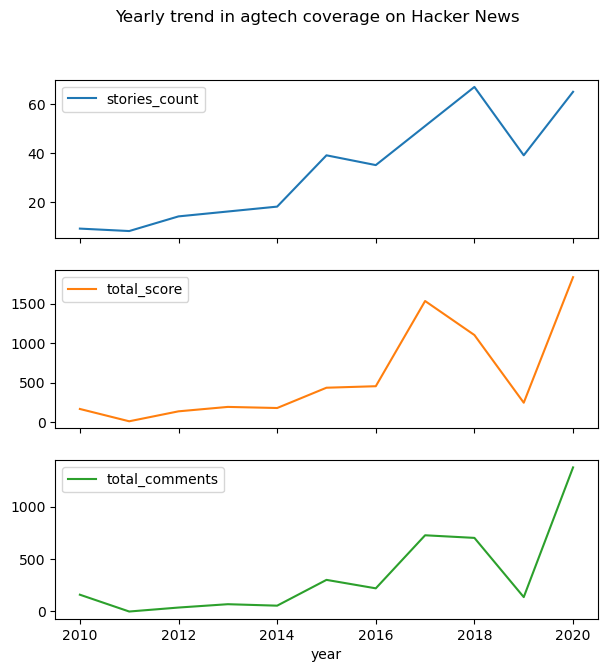

In [39]:
# plot total stories, comments, scores per year
axes = agtech_yearly.plot.line(subplots=True, title='Yearly trend in agtech coverage on Hacker News', figsize=(7,7))

Agtech coverage in terms of number of stories posted has generally increased from 2010 to 2020, although there were dips in 2016 and 2019. It's possible that the drop in 2019 can be partly attributed to agtech stories not being picked up by my selection of bigrams.

In [52]:
# calculate average score and comments per story
agtech_df.groupby('year').agg(
                      avg_score = pd.NamedAgg(column = 'score', aggfunc="mean"),
                      std_score = pd.NamedAgg(column = 'score', aggfunc="std"),
                      avg_comments = pd.NamedAgg(column = 'comments', aggfunc="mean"),
                      std_comments = pd.NamedAgg(column = 'comments', aggfunc="std"))

,avg_score,std_score,avg_comments,std_comments
year,,,,
2007,1.000000,NaN,-1.000000,NaN
2009,1.500000,0.577350,0.000000,0.000000
2010,18.444444,32.101834,17.444444,34.022460
2011,1.250000,0.462910,-0.500000,0.534522
2012,9.714286,29.769444,2.428571,10.839488
2013,12.000000,24.795161,4.400000,12.368162
2014,9.888889,18.556397,3.714286,8.361345
2015,11.153846,21.243623,9.060606,24.448849
2016,12.971429,34.860635,7.032258,22.833431


The traction that stories get differ quite widely, as seen from how the mean score and number of comments per year are much smaller than their standard deviations.

In sum, this exercise in using bigrams, while somewhat tedious, helped to expand the number of agtech-related stories found on Hacker News from 45 stories (in notebook 1) to 371 stories